### 任务目标：利用异烟酸生产过程中的各参数，预测最终异烟酸的收率
- 数据集包括生产工程中10个步骤的参数，样本id、A1-A28、B1-B14包括原料、辅料、时间、温度、压强等以及收率
- 冠军ATCG解决方案

![title](1.png)

In [1]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

warnings.simplefilter('ignore')

In [2]:
df_trn = pd.read_csv(
        'data/jinnan_round1_train_20181227.csv', encoding='GB2312')
df_tst_a = pd.read_csv(
        'data/jinnan_round1_testA_20181227.csv', encoding='GB2312')
df_tst_b = pd.read_csv(
        'data/jinnan_round1_testB_20190121.csv', encoding='GB2312')

In [3]:
df_trn.head()

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B6,B7,B8,B9,B10,B11,B12,B13,B14,收率
0,sample_1528,300,NaN,405.0,700,13:30:00,38.0,NaN,NaN,15:30:00,...,65,11:30:00,45.0,11:30-13:00,14:00-15:30,NaN,800.0,0.15,400,0.879
1,sample_1698,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,80,6:00:00,45.0,6:00-7:30,7:30-9:00,9:00-10:00,1200.0,0.15,400,0.902
2,sample_639,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,80,1:00:00,45.0,1:00-2:30,2:30-4:00,4:00-5:00,1200.0,0.15,400,0.936
3,sample_483,300,NaN,405.0,700,1:30:00,38.0,NaN,NaN,3:00:00,...,65,18:00:00,45.0,19:00-20:30,21:30-23:00,NaN,800.0,0.15,400,0.902
4,sample_617,300,NaN,405.0,700,22:00:00,29.0,NaN,NaN,0:00:00,...,80,9:00:00,45.0,9:00-10:30,10:30-12:00,12:00-13:00,1200.0,0.15,420,0.983


In [4]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 44 columns):
样本id    1396 non-null object
A1      1396 non-null int64
A2      42 non-null float64
A3      1354 non-null float64
A4      1396 non-null int64
A5      1396 non-null object
A6      1396 non-null float64
A7      149 non-null object
A8      149 non-null float64
A9      1396 non-null object
A10     1396 non-null int64
A11     1396 non-null object
A12     1396 non-null int64
A13     1396 non-null float64
A14     1396 non-null object
A15     1396 non-null float64
A16     1396 non-null object
A17     1396 non-null float64
A18     1396 non-null float64
A19     1396 non-null int64
A20     1396 non-null object
A21     1393 non-null float64
A22     1396 non-null float64
A23     1393 non-null float64
A24     1395 non-null object
A25     1396 non-null object
A26     1394 non-null object
A27     1396 non-null int64
A28     1396 non-null object
B1      1386 non-null float64
B2      1394 non-null

In [5]:
df_tst_a

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_1656,300,NaN,405.0,700,6:00:00,29,NaN,NaN,8:00:00,...,15:00:00,79,17:00:00,45,17:00-18:30,18:30-20:00,20:00-21:00,1200,0.15,400
1,sample_1548,300,NaN,405.0,700,12:30:00,39,12:50:00,80.0,14:20:00,...,7:50:00,65,10:00:00,45,12:00-13:00,14:00-15:30,NaN,800,0.15,385
2,sample_769,300,NaN,405.0,700,6:00:00,80,NaN,NaN,8:00:00,...,15:00:00,80,17:00:00,45,17:00-20:00,NaN,NaN,1200,0.15,440
3,sample_1881,300,NaN,405.0,700,22:00:00,29,NaN,NaN,0:00:00,...,7:00:00,80,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400
4,sample_1807,300,NaN,405.0,700,22:00:00,30,NaN,NaN,0:00:00,...,7:00:00,79,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,sample_502,300,NaN,405.0,700,11:00:00,24,NaN,NaN,12:30:00,...,8:00:00,65,10:30:00,45,12:30-14:00,14:30-16:00,NaN,800,0.15,440
146,sample_1951,300,NaN,405.0,700,21:00:00,29,NaN,NaN,23:00:00,...,6:00:00,80,8:00:00,45,8:00-12:00,NaN,NaN,1200,0.15,440
147,sample_386,300,NaN,405.0,700,7:30:00,41,7:40:00,80.0,9:00:00,...,1:30:00,40,4:30:00,20,4:30-6:00,6:00-7:30,NaN,800,0.15,440
148,sample_362,300,NaN,405.0,700,2:00:00,36,2:10:00,80.0,3:30:00,...,13:30:00,65,17:00:00,45,17:00-18:30,19:00-20:30,NaN,800,0.15,420


In [6]:
df_tst_b

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_840,300,125.0,NaN,980,21:00:00,18,NaN,NaN,22:30:00,...,9:30:00,65,12:30:00,45,12:30-14:00,14:30-15:30,NaN,800,0.15,400
1,sample_93,300,NaN,405.0,700,22:00:00,29,NaN,NaN,0:00:00,...,7:00:00,80,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400
2,sample_864,300,NaN,405.0,700,4:30:00,20,NaN,NaN,6:00:00,...,19:30:00,60,21:00:00,40,1:00-3:00,4:00-7:00,NaN,800,0.15,390
3,sample_1488,300,NaN,405.0,700,21:00:00,21,21:30:00,73.0,23:30:00,...,16:30:00,65,21:30:00,45,22:00-23:30,0:30-2:00,NaN,800,0.15,400
4,sample_744,300,NaN,405.0,700,6:00:00,30,NaN,NaN,8:00:00,...,15:00:00,80,17:00:00,45,17:00-20:30,NaN,NaN,1200,0.15,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,sample_517,300,NaN,405.0,700,16:00:00,21,NaN,NaN,17:30:00,...,8:00:00,65,12:00:00,50,12:00-13:30,14:00-15:30,NaN,800,0.15,420
145,sample_1218,300,NaN,405.0,700,6:00:00,29,NaN,NaN,8:00:00,...,15:00:00,74,17:00:00,45,17:00-18:30,18:30-20:00,20:00-21:00,1200,0.15,400
146,sample_1128,300,NaN,405.0,700,18:00:00,29,NaN,NaN,20:00:00,...,3:00:00,80,5:00:00,45,5:00-6:30,6:30-8:00,8:00-9:00,1200,0.15,400
147,sample_1109,300,NaN,405.0,700,9:00:00,29,NaN,NaN,11:00:00,...,3:00:00,80,5:00:00,45,5:00-6:30,6:30-8:00,8:00-9:00,1200,0.15,400


#### 数据检查与问题修正

In [7]:
def train_abnormal_revise(data):
    df_trn = data.copy()
    df_trn.loc[(df_trn['A1'] == 200) & (df_trn['A3'] == 405), 'A1'] = 300
    df_trn['A5'] = df_trn['A5'].replace('1900/1/21 0:00', '21:00:00')
    df_trn['A5'] = df_trn['A5'].replace('1900/1/29 0:00', '14:00:00')
    df_trn['A9'] = df_trn['A9'].replace('1900/1/9 7:00', '23:00:00')
    df_trn['A9'] = df_trn['A9'].replace('700', '7:00:00')
    df_trn['A11'] = df_trn['A11'].replace(':30:00', '00:30:00')
    df_trn['A11'] = df_trn['A11'].replace('1900/1/1 2:30', '21:30:00')
    df_trn['A16'] = df_trn['A16'].replace('1900/1/12 0:00', '12:00:00')
    df_trn['A20'] = df_trn['A20'].replace('6:00-6:30分', '6:00-6:30')
    df_trn['A20'] = df_trn['A20'].replace('18:30-15:00', '18:30-19:00')
    df_trn['A22'] = df_trn['A22'].replace(3.5, np.nan)
    df_trn['A25'] = df_trn['A25'].replace('1900/3/10 0:00', 70).astype(int)
    df_trn['A26'] = df_trn['A26'].replace('1900/3/13 0:00', '13:00:00')
    df_trn['B1'] = df_trn['B1'].replace(3.5, np.nan)
    df_trn['B4'] = df_trn['B4'].replace('15:00-1600', '15:00-16:00')
    df_trn['B4'] = df_trn['B4'].replace('18:00-17:00', '16:00-17:00')
    df_trn['B4'] = df_trn['B4'].replace('19:-20:05', '19:05-20:05')
    df_trn['B9'] = df_trn['B9'].replace('23:00-7:30', '23:00-00:30')
    df_trn['B14'] = df_trn['B14'].replace(40, 400)
    return df_trn


def test_a_abnormal_revise(data):
    df_tst = data.copy()
    df_tst['A5'] = df_tst['A5'].replace('1900/1/22 0:00', '22:00:00')
    df_tst['A7'] = df_tst['A7'].replace('0:50:00', '21:50:00')
    df_tst['B14'] = df_tst['B14'].replace(785, 385)
    return df_tst


def train_abnormal_adjust(data):
    df_trn = data.copy()
    df_trn.loc[df_trn['样本id'] == 'sample_1894', 'A5'] = '14:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1234', 'A9'] = '0:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1020', 'A9'] = '18:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1380', 'A11'] = '15:30:00'
    df_trn.loc[df_trn['样本id'] == 'sample_844', 'A11'] = '10:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1348', 'A11'] = '17:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_25', 'A11'] = '00:30:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1105', 'A11'] = '4:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_313', 'A11'] = '15:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_291', 'A14'] = '19:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1398', 'A16'] = '11:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1177', 'A20'] = '19:00-20:00'

    df_trn.loc[df_trn['样本id'] == 'sample_71', 'A20'] = '16:20-16:50'
    df_trn.loc[df_trn['样本id'] == 'sample_14', 'A20'] = '18:00-18:30'
    df_trn.loc[df_trn['样本id'] == 'sample_69', 'A20'] = '6:10-6:50'
    df_trn.loc[df_trn['样本id'] == 'sample_1500', 'A20'] = '23:00-23:30'

    df_trn.loc[df_trn['样本id'] == 'sample_1524', 'A24'] = '15:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1524', 'A26'] = '15:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1046', 'A28'] = '18:00-18:30'

    df_trn.loc[df_trn['样本id'] == 'sample_1230', 'B5'] = '17:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_97', 'B7'] = '1:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_752', 'B9'] = '11:00-14:00'

    df_trn.loc[df_trn['样本id'] == 'sample_609', 'B11'] = '11:00-12:00'
    df_trn.loc[df_trn['样本id'] == 'sample_643', 'B11'] = '12:00-13:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1164', 'B11'] = '5:00-6:00'
    return df_trn


def test_a_abnormal_adjust(data):
    df_tst = data.copy()
    df_tst.loc[df_tst['样本id'] == 'sample_919', 'A9'] = '19:50:00'
    return df_tst


def test_b_abnormal_adjust(data):
    df_tst = data.copy()
    df_tst.loc[df_tst['样本id'] == 'sample_566', 'A5'] = '18:00:00'
    df_tst.loc[df_tst['样本id'] == 'sample_40', 'A20'] = '5:00-5:30'
    df_tst.loc[df_tst['样本id'] == 'sample_531', 'B5'] = '1:00'
    return df_tst

In [8]:
df_trn = train_abnormal_revise(df_trn).pipe(train_abnormal_adjust)
df_tst_a = test_a_abnormal_revise(df_tst_a).pipe(test_a_abnormal_adjust)
df_tst_b = test_b_abnormal_adjust(df_tst_b)

#### 标签与数据集整合

In [9]:
df_trn, df_tst = df_trn.copy(), df_tst_b.copy()
df_target = df_trn['收率']
del df_trn['收率']
df_trn_tst = df_trn.append(df_tst, ignore_index=False).reset_index(
    drop=True)

In [10]:
# 处理缺失值
for _df in [df_trn, df_tst, df_trn_tst]:
    _df['A3'] = _df['A3'].fillna(405)

#### 时间段特征处理 

In [11]:
# 所有时间相关列
cols_timer = ['A5', 'A7', 'A9', 'A11', 'A14', 'A16', 'A24', 'A26', 'B5', 'B7']
# 同时对训练和测试集进行相同处理
for _df in [df_trn_tst, df_trn, df_tst]:
    # 添加列名标记
    _df.rename(columns={_col: _col + '_t' for _col in cols_timer},
               inplace=True)
    # 遍历所有持续时间相关列例如21:00-21:30
    for _col in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
        # 取到当前列的索引
        _idx_col = _df.columns.tolist().index(_col)
        # 添加新的一列，表示起始时间，split表示分别取开始和结束时间，用索引来指定
        _df.insert(_idx_col + 1, _col + '_at',
                   _df[_col].str.split('-').str[0])
        # 添加新的一列，表示终止时间
        _df.insert(_idx_col + 2, _col + '_bt',
                   _df[_col].str.split('-').str[1])
        # 删除持续时间
        del _df[_col]
        cols_timer = cols_timer + [_col + '_at', _col + '_bt']

In [12]:
df_trn_tst.head()

,样本id,A1,A2,A3,A4,A5_t,A6,A7_t,A8,A9_t,...,B8,B9_at,B9_bt,B10_at,B10_bt,B11_at,B11_bt,B12,B13,B14
0,sample_1528,300,NaN,405.0,700,13:30:00,38.0,NaN,NaN,15:30:00,...,45.0,11:30,13:00,14:00,15:30,NaN,NaN,800.0,0.15,400
1,sample_1698,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,45.0,6:00,7:30,7:30,9:00,9:00,10:00,1200.0,0.15,400
2,sample_639,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,45.0,1:00,2:30,2:30,4:00,4:00,5:00,1200.0,0.15,400
3,sample_483,300,NaN,405.0,700,1:30:00,38.0,NaN,NaN,3:00:00,...,45.0,19:00,20:30,21:30,23:00,NaN,NaN,800.0,0.15,400
4,sample_617,300,NaN,405.0,700,22:00:00,29.0,NaN,NaN,0:00:00,...,45.0,9:00,10:30,10:30,12:00,12:00,13:00,1200.0,0.15,420


In [13]:
cols_timer = list(filter(lambda x: x.endswith('t'), df_trn_tst.columns))

In [14]:
cols_timer

['A5_t',
 'A7_t',
 'A9_t',
 'A11_t',
 'A14_t',
 'A16_t',
 'A20_at',
 'A20_bt',
 'A24_t',
 'A26_t',
 'A28_at',
 'A28_bt',
 'B4_at',
 'B4_bt',
 'B5_t',
 'B7_t',
 'B9_at',
 'B9_bt',
 'B10_at',
 'B10_bt',
 'B11_at',
 'B11_bt']

将时间全部转换成分钟形式

In [15]:
def time_to_min(x):
    if x is np.nan:
        return np.nan
    else:
        x = x.replace(';', ':').replace('；', ':')
        x = x.replace('::', ':').replace('"', ':')
        h, m = x.split(':')[:2]
        h = 0 if not h else h
        m = 0 if not m else m
        return int(h)*60 + int(m)

In [16]:
for _df in [df_trn_tst, df_trn, df_tst]:
    for _col in cols_timer:
        _df[_col] = _df[_col].map(time_to_min)

In [17]:
df_trn_tst.head()

,样本id,A1,A2,A3,A4,A5_t,A6,A7_t,A8,A9_t,...,B8,B9_at,B9_bt,B10_at,B10_bt,B11_at,B11_bt,B12,B13,B14
0,sample_1528,300,NaN,405.0,700,810,38.0,NaN,NaN,930,...,45.0,690,780,840.0,930.0,NaN,NaN,800.0,0.15,400
1,sample_1698,300,NaN,405.0,700,840,29.0,NaN,NaN,960,...,45.0,360,450,450.0,540.0,540.0,600.0,1200.0,0.15,400
2,sample_639,300,NaN,405.0,700,840,29.0,NaN,NaN,960,...,45.0,60,150,150.0,240.0,240.0,300.0,1200.0,0.15,400
3,sample_483,300,NaN,405.0,700,90,38.0,NaN,NaN,180,...,45.0,1140,1230,1290.0,1380.0,NaN,NaN,800.0,0.15,400
4,sample_617,300,NaN,405.0,700,1320,29.0,NaN,NaN,0,...,45.0,540,630,630.0,720.0,720.0,780.0,1200.0,0.15,420


### 创建一个df来准备添加多特征，在新表格逐步添加

In [18]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
df.head()

,样本id
0,sample_1528
1,sample_1698
2,sample_639
3,sample_483
4,sample_617


#### 温度相关特征

In [19]:
# 加热过程
df['P1_S1_A6_0C'] = raw['A6']  # 容器初始温度
df['P1_S2_A8_1C'] = raw['A8']  # 首次测温温度
df['P1_S3_A10_2C'] = raw['A10']  # 准备水解温度
df['P1_C1_C0_D'] = raw['A8'] - raw['A6']  # 测温温差
df['P1_C2_C0_D'] = raw['A10'] - raw['A6']  # 初次沸腾温差

# 水解过程
df['P2_S1_A12_3C'] = raw['A12']  # 水解开始温度
df['P2_S2_A15_4C'] = raw['A15']  # 水解过程测温温度
df['P2_S3_A17_5C'] = raw['A17']  # 水解结束温度
df['P2_C3_C0_D'] = raw['A12'] - raw['A6']  # 水解开始与初始温度温差
df['P2_C3_C2_D'] = raw['A12'] - raw['A10']  # 水解开始前恒温温差
df['P2_C4_C3_D'] = raw['A15'] - raw['A12']  # 水解过程中途温差
df['P2_C5_C4_D'] = raw['A17'] - raw['A15']  # 水解结束中途温差
df['P2_C5_C3_KD'] = raw['A17'] - raw['A12']  # 水解起止温差

# 脱色过程
df['P3_S2_A25_7C'] = raw['A25']  # 脱色保温开始温度
df['P3_S3_A27_8C'] = raw['A27']  # 脱色保温结束温度
df['P3_C7_C5_D'] = raw['A25'] - raw['A17']  # 降温温差
df['P3_C8_C7_KD'] = raw['A27'] - raw['A25']  # 保温温差

# 结晶过程
df['P4_S2_B6_11C'] = raw['B6']  # 结晶开始温度
df['P4_S3_B8_12C'] = raw['B8']  # 结晶结束温度
df['P4_C11_C8_D'] = raw['B6'] - raw['A27']  # 脱色结束到结晶温差
df['P4_C12_C11_KD'] = raw['B8'] - raw['B6']  # 结晶温差

#### 温度相关统计特征

In [20]:
_funcs = ['mean', 'std', 'sum']
# 遍历每一种统计指标，横向计算
for _func in _funcs:
    # 对每一个样本计算各项指标
    df[f'P2_C2-C5_{_func}'] = raw[['A10', 'A12', 'A15', 'A17']].\
        agg(_func, axis=1)  # 沸腾过程温度
    df[f'P2_D3-D5_{_func}'] = \
        df[[f'P2_C{i}_C{i-1}_D' for i in range(3, 6)]].\
            abs().agg(_func, axis=1)  # 沸腾过程绝对温差
    df[f'P2_C1-C12_KD_ABS_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('KD')]].\
            abs().agg(_func, axis=1)  # 关键过程绝对温差
    df[f'P2_C1-C12_D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('D')]].\
            abs().agg(_func, axis=1)  # 所有过程绝对温差
    df[f'P2_LARGE_KD_{_func}'] = \
        df[['P2_C3_C0_D', 'P3_C7_C5_D', 'P4_C12_C11_KD']].\
            abs().agg(_func, axis=1)  # 大温差绝对温差

In [21]:
df.head()

,样本id,P1_S1_A6_0C,P1_S2_A8_1C,P1_S3_A10_2C,P1_C1_C0_D,P1_C2_C0_D,P2_S1_A12_3C,P2_S2_A15_4C,P2_S3_A17_5C,P2_C3_C0_D,...,P2_C2-C5_std,P2_D3-D5_std,P2_C1-C12_KD_ABS_std,P2_C1-C12_D_std,P2_LARGE_KD_std,P2_C2-C5_sum,P2_D3-D5_sum,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum
0,sample_1528,38.0,NaN,100,NaN,62.0,102,103.0,104.0,64.0,...,1.707825,0.57735,9.643651,24.928565,23.245071,409.0,4.0,27.0,191.0,113.0
1,sample_1698,29.0,NaN,101,NaN,72.0,103,104.0,105.0,74.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0
2,sample_639,29.0,NaN,102,NaN,73.0,103,104.0,105.0,74.0,...,1.290994,0.00000,18.009257,29.231642,25.514702,414.0,3.0,43.0,226.0,135.0
3,sample_483,38.0,NaN,100,NaN,62.0,102,103.0,104.0,64.0,...,1.707825,0.57735,9.165151,24.617293,22.479620,409.0,4.0,30.0,207.0,118.0
4,sample_617,29.0,NaN,101,NaN,72.0,103,104.0,105.0,74.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0


得到温度相关特征

In [22]:
df_temperature = df.set_index('样本id')

In [23]:
df_temperature.head()

,P1_S1_A6_0C,P1_S2_A8_1C,P1_S3_A10_2C,P1_C1_C0_D,P1_C2_C0_D,P2_S1_A12_3C,P2_S2_A15_4C,P2_S3_A17_5C,P2_C3_C0_D,P2_C3_C2_D,...,P2_C2-C5_std,P2_D3-D5_std,P2_C1-C12_KD_ABS_std,P2_C1-C12_D_std,P2_LARGE_KD_std,P2_C2-C5_sum,P2_D3-D5_sum,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum
样本id,,,,,,,,,,,,,,,,,,,,,
sample_1528,38.0,NaN,100,NaN,62.0,102,103.0,104.0,64.0,2,...,1.707825,0.57735,9.643651,24.928565,23.245071,409.0,4.0,27.0,191.0,113.0
sample_1698,29.0,NaN,101,NaN,72.0,103,104.0,105.0,74.0,2,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0
sample_639,29.0,NaN,102,NaN,73.0,103,104.0,105.0,74.0,1,...,1.290994,0.00000,18.009257,29.231642,25.514702,414.0,3.0,43.0,226.0,135.0
sample_483,38.0,NaN,100,NaN,62.0,102,103.0,104.0,64.0,2,...,1.707825,0.57735,9.165151,24.617293,22.479620,409.0,4.0,30.0,207.0,118.0
sample_617,29.0,NaN,101,NaN,72.0,103,104.0,105.0,74.0,2,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0


#### 时间相关特征

In [24]:
# 时间计算方式转换
def duration_outer(series1, series2):
    duration = series1 - series2
    duration = np.where(duration < 0, duration + 24*60, duration)  # 处理跨天时间计算问题
    duration = np.where(duration > 12*60, 24*60 - duration, duration)
    duration = np.where(duration > 6*60, 12*60 - duration, duration)
    return duration

In [25]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
# 加热过程
df['P1_S1_A5_0T'] = raw['A5_t']  # 初始时刻
df['P1_S2_A9_2T'] = raw['A9_t']  # 初始时刻
df['P1_T1_T0_D'] = duration_outer(raw['A7_t'], raw['A5_t'])
# 初次测温时间差
df['P1_T2_T1_D'] = duration_outer(raw['A9_t'], raw['A7_t'])
# 二次测温时间差
df['P1_T2_T0_K_D'] = duration_outer(raw['A9_t'], raw['A5_t'])
# 开始加热至沸腾时间差

# 水解过程
df['P2_S1_A11_3T'] = raw['A11_t']  # 水解开始时刻
df['P2_S1_A16_5T'] = raw['A16_t']  # 水解结束时刻

df['P2_T3_T0_K_D'] = duration_outer(raw['A11_t'], raw['A5_t'])
# 开始加热至投料时间差
df['P2_T3_T2_K_D'] = duration_outer(raw['A11_t'], raw['A9_t'])
# 恒温至投料投料时间差
# df['P2_T4_T3_D'] = raw['A14_t'] - raw['A11_t']  # 水解初次测温时间差
# df['P2_T5_T4_D'] = raw['A16_t'] - raw['A14_t']  # 水解结束时间差
df['P2_T5_T3_K_D'] = duration_outer(raw['A16_t'], raw['A11_t'])
# 水解时间差

# 脱色过程
df['P3_S1_A20_6T'] = raw['A20_at']  # 中和开始时刻
df['P3_S2_A25_7T'] = raw['A24_t']  # 保温时刻

df['P3_T6_T5_K_D'] = duration_outer(raw['A20_at'], raw['A16_t'])
# 水解结束至中和间歇时间
df['P3_T6_T6_K_D'] = duration_outer(raw['A20_bt'], raw['A20_at'])
# 酸碱度中和时间
df['P3_T7_T6_D'] = duration_outer(raw['A24_t'], raw['A20_bt'])
# 中和结束至脱色间歇时间
df['P3_T8_T7_K_D'] = duration_outer(raw['A26_t'], raw['A24_t'])
# 脱色保温时间
df['P3_T9_T8_D'] = duration_outer(raw['A28_at'], raw['A26_t'])
# 脱色至抽滤间歇时间
df['P3_T9_T9_K_D'] = duration_outer(raw['A28_bt'], raw['A28_at'])
# 抽滤时间
df['P3_T9_T5_1D'] = duration_outer(raw['A28_bt'], raw['A16_t'])
df['P3_T9_T6_2D'] = duration_outer(raw['A28_bt'], raw['A20_at'])
# 脱色总时间

# 结晶过程
df['P4_S1_B4_10T'] = raw['B4_at']  # 酸化开始时刻
df['P4_S2_B5_11T'] = raw['B5_t']  # 结晶开始时刻
df['P4_S3_B7_12T'] = raw['B7_t']  # 结晶结束时刻

df['P4_T10_T9_D'] = duration_outer(raw['B4_at'], raw['A28_bt'])
# 抽滤结束至酸化间歇时间
df['P4_T10_T10_K_D'] = duration_outer(raw['B4_bt'], raw['B4_at'])
# 酸化时间
df['P4_T11_T10_K_D'] = duration_outer(raw['B5_t'], raw['B4_bt'])
# 酸化至结晶间歇时间
df['P4_T12_T11_K_D'] = duration_outer(raw['B7_t'], raw['B5_t'])
# 自然结晶时间
df['P4_T12_T9_1D'] = duration_outer(raw['B7_t'], raw['A28_bt'])
df['P4_T12_T10_2D'] = duration_outer(raw['B7_t'], raw['B4_at'])
# 结晶总时间

# 甩滤过程
df['P5_S1_B9_13T'] = raw['B9_at']  # 甩滤开始时刻
df['P5_S3_B12_15T'] = np.where(
    raw['B11_bt'].isnull(),
    np.where(raw['B10_bt'].isnull(), raw['B9_bt'], raw['B10_bt']),
    raw['B11_bt'])  # 甩滤结束时刻
df['P5_T13_T12_D'] = duration_outer(raw['B9_at'], raw['B7_t'])
# 酸化结束至甩滤间歇时间
df['P5_T13_T13_K_D'] = duration_outer(raw['B9_bt'], raw['B9_at'])
# 基本甩滤时间
df['P5_T14_T13_D'] = duration_outer(raw['B10_at'], raw['B9_bt'])
# 基本甩滤至补充甩滤1间歇时间
df['P5_T14_T14_K_D'] = duration_outer(raw['B10_bt'], raw['B10_at'])
# 补充甩滤1时间
df['P5_T15_T14_D'] = duration_outer(raw['B11_at'], raw['B10_bt'])
# 补充甩滤1至补充甩滤2间歇时间
df['P5_T15_T13_K_D'] = duration_outer(raw['B11_bt'], raw['B11_at'])
# 补充甩滤2时间
df['P5_T15_T13_1D'] = \
    df[['P5_T13_T13_K_D', 'P5_T14_T14_K_D', 'P5_T13_T13_K_D']].sum(axis=1)
df['P5_T15_T12_2D'] = duration_outer(
    df['P5_S3_B12_15T'], df['P4_S3_B7_12T'])
df['P5_T15_T12_3D'] = duration_outer(
    df['P5_S3_B12_15T'], df['P5_S1_B9_13T'])
# 总甩滤时间

# 总流程时长
df['P5_T15_T1_4D'] = \
    df[['P5_T15_T12_2D', 'P4_T12_T9_1D', 'P3_T9_T5_1D',
        'P2_T3_T0_K_D', 'P2_T5_T3_K_D']].sum(axis=1)
_funcs = ['mean', 'std', 'sum']
for _func in _funcs:
    df[f'P5__D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('_D')]].\
            abs().agg(_func, axis=1)
    df[f'P5_K_D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('_K_D')]]. \
            abs().agg(_func, axis=1)
    df[f'P5__D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('D')]]. \
            abs().agg(_func, axis=1)
df_duration = df.set_index('样本id')

In [26]:
df_duration.head()

,P1_S1_A5_0T,P1_S2_A9_2T,P1_T1_T0_D,P1_T2_T1_D,P1_T2_T0_K_D,P2_S1_A11_3T,P2_S1_A16_5T,P2_T3_T0_K_D,P2_T3_T2_K_D,P2_T5_T3_K_D,...,P5_T15_T13_1D,P5_T15_T12_2D,P5_T15_T12_3D,P5_T15_T1_4D,P5__D_mean,P5_K_D_mean,P5__D_std,P5_K_D_std,P5__D_sum,P5_K_D_sum
样本id,,,,,,,,,,,,,,,,,,,,,
sample_1528,810,930,NaN,NaN,120,990,1110,180,60,120,...,270.0,240.0,240.0,840.0,145.384615,90.000000,169.852425,63.639610,3780.0,1170.0
sample_1698,840,960,NaN,NaN,120,1020,1140,180,60,120,...,270.0,240.0,240.0,960.0,136.071429,90.000000,188.588113,76.258669,3810.0,1260.0
sample_639,840,960,NaN,NaN,120,1020,1140,180,60,120,...,270.0,240.0,240.0,900.0,123.214286,75.000000,173.654693,49.575118,3450.0,1050.0
sample_483,90,180,NaN,NaN,90,240,360,150,60,120,...,270.0,300.0,240.0,990.0,158.076923,73.846154,195.448596,46.822086,4110.0,960.0
sample_617,1320,0,NaN,NaN,120,60,180,180,60,120,...,270.0,240.0,240.0,900.0,123.214286,77.142857,173.846539,48.107024,3450.0,1080.0


#### 水耗相关特征

In [27]:
na_value=405

df_trn_tst = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
# 耗水
df['P2_W_1M'] = raw['A4']
df['P2_W_2M'] = raw['A19']
# 耗盐酸
df['P3_H_1M'] = raw['A21'].fillna(50)
df['P4_H_2M'] = raw['B1'].fillna(320)
# 氢氧化钠
df['P2_N_1M'] = raw['A3'].fillna(na_value)
# 4-氰基吡啶
df['P2_C_1M'] = raw['A1']

df['P5_W_3M'] = raw['B12'].fillna(1200)
df['P5_W_1M'] = df['P2_W_1M'] + df['P2_W_2M']
df['P5_W_3M'] = df['P2_W_1M'] + df['P2_W_2M'] + df['P5_W_3M']
df['P5_H_1M'] = df['P3_H_1M'] + df['P4_H_2M']
df['P5_M_0M'] = raw['A1'] + df['P2_N_1M'] + df['P5_W_1M'] + df['P4_H_2M']
df['P5_M_1M'] = df['P5_M_0M'] + df['P5_W_3M']
df['P5_M_2M'] = df['P5_M_1M'] + df['P3_H_1M']
# 理论产出
df['P5_O_1M'] = raw['B14']
df['P5_O_5M'] = raw['B14'].replace(418, 420).replace(405, 400).\
    replace(395, 390).replace(392, 390).replace(387, 380).\
    replace(385, 380).replace(370, 360).replace(350, 360).\
    replace(350, 360).replace(340, 360).replace(290, 280).\
    replace(260, 280).replace(256, 280)
_fs = [_f for _f in df.columns if _f.endswith('M')]
for _f in _fs[:-2]:
    df[f'{_f}_P5_O_1M_R'] = df['P5_O_1M'] / df[_f]
    df[f'{_f}_P5_O_5M_R'] = df['P5_O_5M'] / df[_f]
for i in range(len(_fs[:6])):
    _f, _sub_fs = _fs[i], _fs[(i+1):6]
    for _f_div in _sub_fs:
        df[f'{_f}_{_f_div}_R'] = df[_f] / df[_f_div]
df_materials = df.set_index('样本id')

In [28]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
df['P5_NOT_NUM_N'] = raw.iloc[:, 1:-1].notnull().sum(axis=1)
df['P5_PH_1N'] = raw['A22']
df['P5_PH_2N'] = raw['A23']
df['P5_PH_2N'] = raw['B2']
df['P5_A7_1N'] = raw['A7_t'].isnull().astype(int)
df['P5_O_2M'] = (raw['B14'] <= 360).astype(int)
df['P5_1_3M'] = raw['B13']
df_interact = df.set_index('样本id')

In [29]:
df_interact.head()

,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M
样本id,,,,,,
sample_1528,42,9.0,3.5,1,0,0.15
sample_1698,44,9.0,3.5,1,0,0.15
sample_639,44,9.0,3.5,1,0,0.15
sample_483,42,10.0,3.5,1,0,0.15
sample_617,44,9.0,3.5,1,0,0.15


### 合并所有特征

In [30]:
# 合并物料、时间、温度、压强PH特征
df_feature = pd.concat([df_materials, df_duration, df_temperature, df_interact], axis=1).reset_index()

In [31]:
df_feature

,样本id,P2_W_1M,P2_W_2M,P3_H_1M,P4_H_2M,P2_N_1M,P2_C_1M,P5_W_3M,P5_W_1M,P5_H_1M,...,P2_D3-D5_sum,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M
0,sample_1528,700,300,50.0,350.0,405.0,300,1800.0,1000,400.0,...,4.0,27.0,191.0,113.0,42,9.0,3.5,1,0,0.15
1,sample_1698,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,4.0,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15
2,sample_639,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,3.0,43.0,226.0,135.0,44,9.0,3.5,1,0,0.15
3,sample_483,700,200,50.0,290.0,405.0,300,1700.0,900,340.0,...,4.0,30.0,207.0,118.0,42,10.0,3.5,1,0,0.15
4,sample_617,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,4.0,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,sample_517,700,300,50.0,320.0,405.0,300,1800.0,1000,370.0,...,5.0,26.0,239.0,131.0,42,9.0,3.5,1,0,0.15
1541,sample_1218,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,4.0,33.0,211.0,128.0,44,9.0,3.5,1,0,0.15
1542,sample_1128,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,4.0,72.0,282.0,134.0,44,9.0,3.5,1,0,0.15
1543,sample_1109,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,4.0,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15


In [32]:
# 再次划分训练集和测试集
df_trn = df_feature.iloc[:len(df_trn)].reset_index(drop=True)
df_trn['收率'] = df_target
df_tst = df_feature.iloc[len(df_trn):].reset_index(drop=True)
df_tst['收率'] = np.nan

In [33]:
df_trn

,样本id,P2_W_1M,P2_W_2M,P3_H_1M,P4_H_2M,P2_N_1M,P2_C_1M,P5_W_3M,P5_W_1M,P5_H_1M,...,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M,收率
0,sample_1528,700,300,50.0,350.0,405.0,300,1800.0,1000,400.0,...,27.0,191.0,113.0,42,9.0,3.5,1,0,0.15,0.879
1,sample_1698,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.902
2,sample_639,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,43.0,226.0,135.0,44,9.0,3.5,1,0,0.15,0.936
3,sample_483,700,200,50.0,290.0,405.0,300,1700.0,900,340.0,...,30.0,207.0,118.0,42,10.0,3.5,1,0,0.15,0.902
4,sample_617,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,sample_836,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,228.0,135.0,40,9.0,3.5,1,0,0.15,0.930
1392,sample_1217,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,42.0,226.0,136.0,44,9.0,3.5,1,0,0.15,0.971
1393,sample_1654,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.891
1394,sample_560,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.902


In [34]:
for _df in [df_trn, df_tst]:
    _df.insert(1, 'id', _df['样本id'].str.split('_').str[1].astype(float))

In [35]:
df_trn.head()

,样本id,id,P2_W_1M,P2_W_2M,P3_H_1M,P4_H_2M,P2_N_1M,P2_C_1M,P5_W_3M,P5_W_1M,...,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M,收率
0,sample_1528,1528.0,700,300,50.0,350.0,405.0,300,1800.0,1000,...,27.0,191.0,113.0,42,9.0,3.5,1,0,0.15,0.879
1,sample_1698,1698.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.902
2,sample_639,639.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,43.0,226.0,135.0,44,9.0,3.5,1,0,0.15,0.936
3,sample_483,483.0,700,200,50.0,290.0,405.0,300,1700.0,900,...,30.0,207.0,118.0,42,10.0,3.5,1,0,0.15,0.902
4,sample_617,617.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.983


筛选常规数据

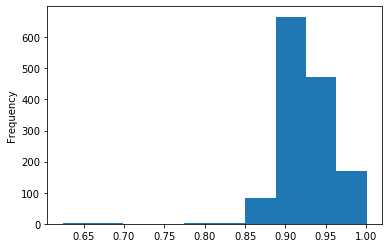

In [36]:
import matplotlib.pyplot as plt
df_trn['收率'].plot(kind='hist')
plt.show()

In [37]:
df_trn = df_trn.query('收率 > 0.8671').reset_index(drop=True)
df_trn = df_trn.query('收率 < 0.9861').reset_index(drop=True)

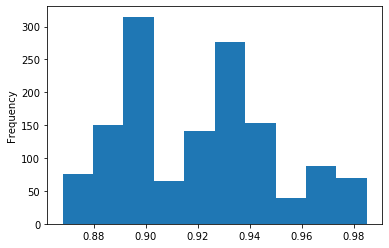

In [38]:
df_trn['收率'].plot(kind='hist')
plt.show()

### 训练模型

In [39]:
def xgb_cv(train, test, params, fit_params, feature_names, nfold, seed):
    # 创建结果df
    train_pred = pd.DataFrame({
        'id': train['样本id'],
        'true': train['收率'],
        'pred': np.zeros(len(train))})
    # 测试提交结果
    test_pred = pd.DataFrame({'id': test['样本id'], 'pred': np.zeros(len(test))})
    # 交叉验证
    kfolder = KFold(n_splits=nfold, shuffle=True, random_state=seed)
    # 构造测试DMatrix
    xgb_tst = xgb.DMatrix(data=test[feature_names])
    print('\n')
    # 遍历cv中每一折数据，通过索引来指定，kfold返回是训练和验证集的索引
    for fold_id, (trn_idx, val_idx) in enumerate(kfolder.split(train['收率'])):
        # 构造当前训练的DMatrix
        xgb_trn = xgb.DMatrix(
            train.iloc[trn_idx][feature_names],
            train.iloc[trn_idx]['收率'])
        # 构造当前验证的DMatrix
        xgb_val = xgb.DMatrix(
            train.iloc[val_idx][feature_names],
            train.iloc[val_idx]['收率'])
        # 训练回归模型
        xgb_reg = xgb.train(params=params, dtrain=xgb_trn, **fit_params,
                  evals=[(xgb_trn, 'train'), (xgb_val, 'valid')])
        # 得到验证结果
        val_pred = xgb_reg.predict(
            xgb.DMatrix(train.iloc[val_idx][feature_names]),
            ntree_limit=xgb_reg.best_ntree_limit)
        train_pred.loc[val_idx, 'pred'] = val_pred
        print(f'Fold_{fold_id}', mse(train.iloc[val_idx]['收率'], val_pred))
        test_pred['pred'] += xgb_reg.predict(
            xgb_tst, ntree_limit=xgb_reg.best_ntree_limit) / nfold
    print('\nCV LOSS:', mse(train_pred['true'], train_pred['pred']), '\n')
    return test_pred

设置训练参数

In [40]:
fit_params = {'num_boost_round': 10800,
              'verbose_eval': 300,
              'early_stopping_rounds': 360}
params_xgb = {'eta': 0.01, 'max_depth': 7, 'subsample': 0.8,
              'booster': 'gbtree', 'colsample_bytree': 0.8,
              'objective': 'reg:linear', 'silent': True, 'nthread': 8}

In [41]:
# 开始训练
pred_xgb_a = xgb_cv(df_trn, df_tst, params_xgb, fit_params,df_trn.columns.tolist()[1:-1], 5, 0)



[10:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:04:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.42052	valid-rmse:0.41795
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 360 rounds.
[300]	train-rmse:0.02372	valid-rmse:0.02367
[600]	train-rmse:0.00646	valid-rmse:0.01147
[900]	train-rmse:0.00473	valid-rmse:0.01170
Stopping. Best iteration:
[571]	train-rmse:0.00676	valid-rmse:0.01146

[10:04:35] WARNING: C:/Users/Administrator/wor

In [42]:
# 得到预测结果
df_tst_b['收率'] = pred_xgb_a['pred'].values

In [43]:
df_tst_b.head()

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B6,B7,B8,B9,B10,B11,B12,B13,B14,收率
0,sample_840,300,125.0,NaN,980,21:00:00,18,NaN,NaN,22:30:00,...,65,12:30:00,45,12:30-14:00,14:30-15:30,NaN,800,0.15,400,0.896042
1,sample_93,300,NaN,405.0,700,22:00:00,29,NaN,NaN,0:00:00,...,80,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400,0.901376
2,sample_864,300,NaN,405.0,700,4:30:00,20,NaN,NaN,6:00:00,...,60,21:00:00,40,1:00-3:00,4:00-7:00,NaN,800,0.15,390,0.886017
3,sample_1488,300,NaN,405.0,700,21:00:00,21,21:30:00,73.0,23:30:00,...,65,21:30:00,45,22:00-23:30,0:30-2:00,NaN,800,0.15,400,0.894656
4,sample_744,300,NaN,405.0,700,6:00:00,30,NaN,NaN,8:00:00,...,80,17:00:00,45,17:00-20:30,NaN,NaN,1200,0.15,440,0.932825
